# Forecasting Aggregate Income Using SARIMAX Model

Install the necessary packages

In [1]:
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 4.1 MB/s 
     |████████████████████████████████| 9.8 MB 41.4 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv("/content/drive/MyDrive/Time Series/VAR/macrodata.csv",index_col='Date',parse_dates=True)
data.head()

,realgdp,realcons,realinv
Date,,,
1959-03-31,2710.349,1707.4,286.898
1959-06-30,2778.801,1733.7,310.859
1959-09-30,2775.488,1751.8,289.226
1959-12-31,2785.204,1753.7,299.356
1960-03-31,2847.699,1770.5,331.722


In this exercise, we shall utilize ARIMA model to forecast realgdp without incorporating the exogenous variables which are realcons and realinv.  After fitting the model, we shall examine the effect of the exogenous variables on the performance of our forecast.

In [4]:
data.index.freq='Q'

# Visualization of the variable

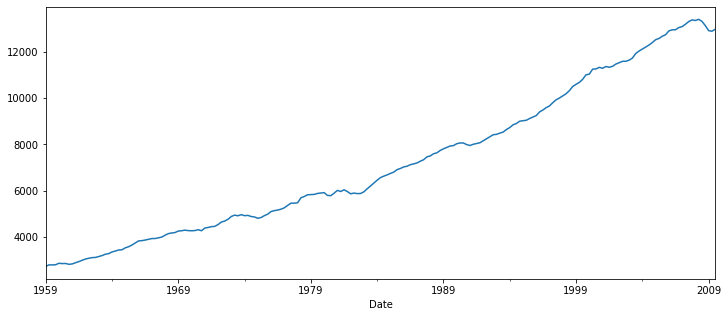

In [5]:
data['realgdp'].plot(figsize=(12,5))

The data display an obvious trend, but we need to find out if it also have seasonality.

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

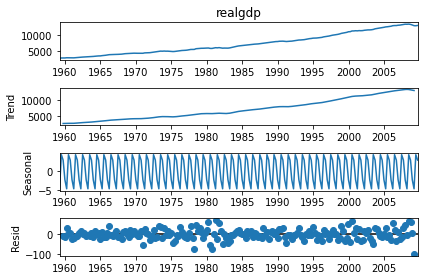

In [9]:
res = seasonal_decompose(data['realgdp'])
res.plot();

The plot shows some seasonal component inherent in the data.

# Use autoarima to determine order of pdq

In [10]:
from pmdarima.arima import auto_arima

In [11]:
res_auto = auto_arima(data['realgdp'],seasonal=True,m=4)
print(res_auto.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  203
Model:               SARIMAX(2, 2, 1)   Log Likelihood               -1088.002
Date:                Sun, 13 Mar 2022   AIC                           2184.005
Time:                        02:08:17   BIC                           2197.218
Sample:                             0   HQIC                          2189.351
                                - 203                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3288      0.053      6.147      0.000       0.224       0.434
ar.L2          0.1813      0.055      3.306      0.001       0.074       0.289
ma.L1         -0.9850      0.014    -70.394      0.0

The auto arima_arima returned order 2,2,1 but did not find any order for the seasonal component.

# Split the data into training and test sets and fit the arima model

In [12]:
train_df = data[:-12]
test_df = data[-12:]

In [13]:
print(train_df.shape,test_df.shape)

(191, 3) (12, 3)


In [14]:
# fit the model on train_df

from statsmodels.tsa.statespace.sarimax import SARIMAX

In [15]:
model = SARIMAX(train_df['realgdp'],order=(2,2,1))
model_res = model.fit()
print(model_res.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                realgdp   No. Observations:                  191
Model:               SARIMAX(2, 2, 1)   Log Likelihood               -1006.629
Date:                Sun, 13 Mar 2022   AIC                           2021.258
Time:                        02:16:50   BIC                           2034.225
Sample:                    03-31-1959   HQIC                          2026.512
                         - 09-30-2006                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2117      0.073      2.903      0.004       0.069       0.355
ar.L2          0.2011      0.062      3.230      0.001       0.079       0.323
ma.L1         -0.9708      0.019    -50.854      0.0

## Model Diagnostics

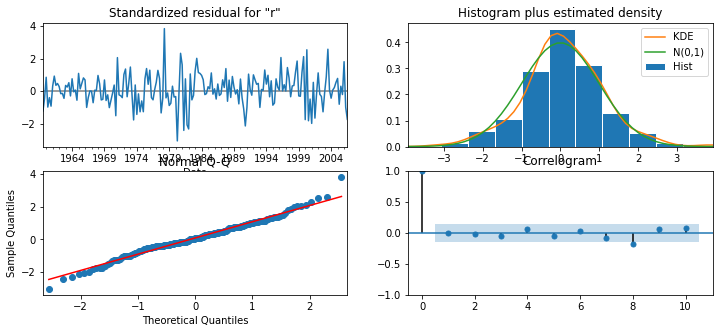

In [17]:
model_res.plot_diagnostics(figsize=(12,5));

The model residuals looks pretty good as the KDE line follows a distribution of zero mean and standard deviation of 1 [n(0,1)].  Moreover, the qq plot shows that almost all the blue dots lies on the red line which indicates that the residuals are normally distributed.

# Obtain the predictions

In [18]:
start = len(train_df)
end = len(train_df)+len(test_df)-1
pred = model_res.predict(start,end,dynamic=False).rename('Predictions')

# Visualize the predictions with the test sets

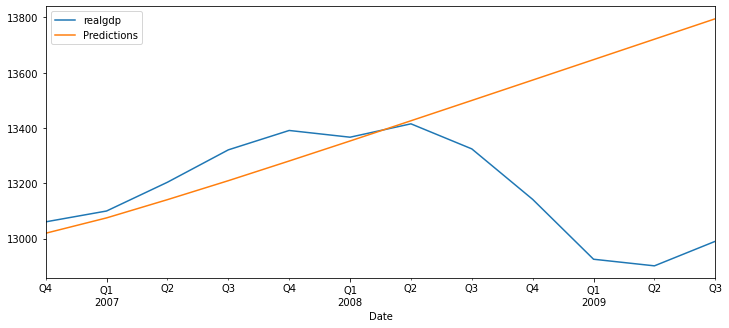

In [19]:
test_df['realgdp'].plot(figsize=(12,5),legend=True)
pred.plot(legend=True);

The forecast did perform well for the periods Q4:2006 - Q2:2008 which is about a year and half period.  Lets compute the values to see the extent of deviation of the prediction from the actual dataset.

In [20]:
test_df['predictions'] = pred
test_df['Deviation (%)'] = round(abs((test_df['realgdp']-test_df['predictions'])/test_df['realgdp'])*100,3)
test_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,realgdp,realcons,realinv,predictions,Deviation (%)
Date,,,,,
2006-12-31,13060.679,9181.6,2165.966,13019.477451,0.315
2007-03-31,13099.901,9265.1,2132.609,13074.983511,0.190
2007-06-30,13203.977,9291.5,2162.214,13140.979088,0.477
2007-09-30,13321.109,9335.6,2166.491,13209.586264,0.837
2007-12-31,13391.249,9363.6,2123.426,13280.855986,0.824
2008-03-31,13366.865,9349.6,2082.886,13353.214591,0.102
2008-06-30,13415.266,9351.0,2026.518,13426.339203,0.083
2008-09-30,13324.600,9267.7,1990.693,13499.844969,1.315
2008-12-31,13141.920,9195.3,1857.661,13573.585485,3.285


The deviation of the forecast from the actual values was acutally less than 1% between Q4:2006 and Q2:2008.  The divergence got a bit wider from Q4:2008 onwards.


# Evaluations

In [23]:
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

In [25]:
rmse(test_df['realgdp'],pred)

417.32374193622303

In [26]:
mean_squared_error(test_df['realgdp'],pred)

174159.10558365125

# Estimation with Exogenous Variables

In [27]:
model_X = SARIMAX(train_df['realgdp'],exog = train_df[['realcons','realinv']], order=(2,2,1))
modelx_res = model_X.fit()
print(modelx_res.summary())

                               SARIMAX Results                                
Dep. Variable:                realgdp   No. Observations:                  191
Model:               SARIMAX(2, 2, 1)   Log Likelihood                -837.317
Date:                Sun, 13 Mar 2022   AIC                           1686.634
Time:                        03:05:35   BIC                           1706.085
Sample:                    03-31-1959   HQIC                          1694.514
                         - 09-30-2006                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
realcons       0.8987      0.046     19.337      0.000       0.808       0.990
realinv        0.9890      0.035     28.633      0.000       0.921       1.057
ar.L1         -0.0509      0.074     -0.688      0.4

In [29]:
start = len(train_df)
end = len(train_df)+len(test_df)-1
pred_x = modelx_res.predict(start,end, exog = test_df[['realcons','realinv']],dynamic=False).rename('PredX')

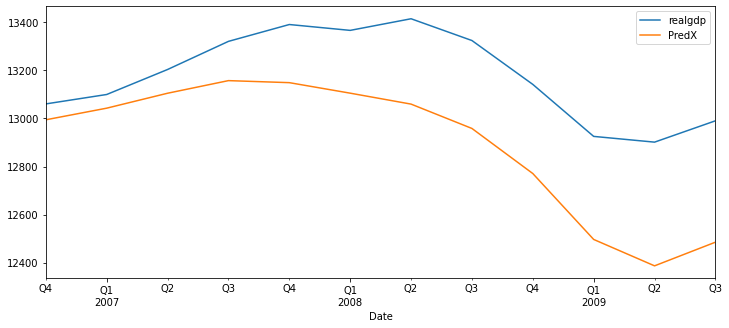

In [30]:
test_df['realgdp'].plot(figsize=(12,5),legend=True)
pred_x.plot(legend=True);

In [31]:
rmse(test_df['realgdp'],pred_x)

325.83731894084633

# Conclusions

The SARIMAX model performed very much better than the SARIMA model.  The rmse of 326 is lower than that of the SARIMA which was 417.  

The intuition behind this analysis is that, building a model that forecast the future requires an understanding of exogenous variables that influences the endogenous variable.  This can easily be found out by doing a brief literature search on the subject of analysis, this will provide the list of exogenous factors that drives the endogenous variable.

Thanks for reading.